In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold, GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,f1_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from warnings import filterwarnings
filterwarnings('ignore')

## Stroke Prediction Dataset

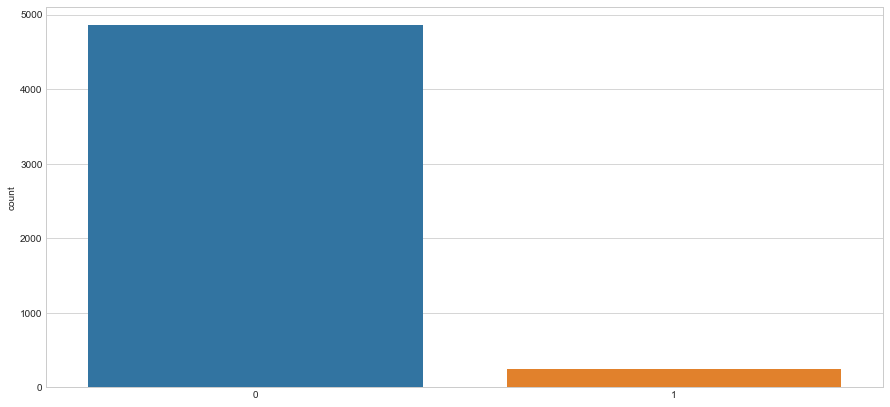

In [10]:
# Stroke dataset
stroke_df = pd.read_csv('./healthcare-dataset-stroke-data.csv')

# Encode categorical features
stroke_df['gender'] = LabelEncoder().fit_transform(stroke_df['gender'])
stroke_df['ever_married'] = LabelEncoder().fit_transform(stroke_df['ever_married'])
stroke_df['Residence_type'] = LabelEncoder().fit_transform(stroke_df['Residence_type'])
stroke_df = pd.get_dummies(data=stroke_df, columns=['smoking_status', 'work_type'])

# fill in missing data
stroke_df['bmi'].fillna(stroke_df['bmi'].median(), inplace=True)

# scale numeric features
columns = ['avg_glucose_level', 'bmi', 'age']
scaler = StandardScaler()
stroke_df[columns] = pd.DataFrame(scaler.fit_transform(
    stroke_df[columns].values), columns=columns, index=stroke_df.index)

# Drop uneeded data
stroke_df.drop(['id'], axis=1, inplace=True)

X = stroke_df.drop(columns=['stroke'])
X = X[:].values
y = stroke_df['stroke'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=555, shuffle=True) 

ax, fig = plt.subplots(figsize=[15,7])
sns.countplot(x = y, data = stroke_df)

# Oversample with Smote
sampler = SMOTE(random_state=123)
X_train, y_train = sampler.fit_resample(X_train, y_train)

stroke_data = X_train, X_test, y_train, y_test


## EMG Gesture Dataset

11678


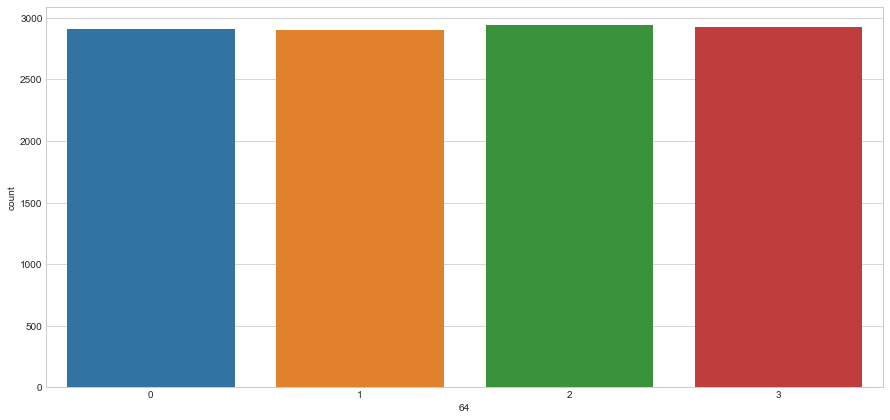

In [11]:
# Muscle Activity Gestures Dataset

gesture_df1 = pd.read_csv("./0.csv", header=None)
gesture_df2 = pd.read_csv("./1.csv", header=None)
gesture_df3 = pd.read_csv("./2.csv", header=None)
gesture_df4 = pd.read_csv("./3.csv", header=None)

# Prep data
gesture_df = pd.concat([gesture_df1, gesture_df2, gesture_df3, gesture_df4], axis=0)

ax, fig = plt.subplots(figsize=[15,7])
sns.countplot(x = 64, data = gesture_df)


X = gesture_df.drop(columns=[64])
X = X[:].values
y = gesture_df[64].values


print(len(y))

# Scale X features
# X = StandardScaler().fit_transform(X)

# sns.countplot(x = gesture_df[:,64], data = gesture_df)

gesture_data = train_test_split(X, y, test_size=0.30, random_state=555, shuffle=True)

In [12]:


def get_all_results(y_test, y_pred, type):
	if type == 'gesture':
		f1 = f1_score(y_test, y_pred,average='micro')
		recall = recall_score(y_test, y_pred,average='micro')
	else:
		f1 = f1_score(y_test, y_pred)
		recall = recall_score(y_test, y_pred)
	accuracy = accuracy_score(y_test, y_pred)

	return {
		'f1': f1,
		'accuracy_score': accuracy,
		'recall': recall
	}


In [13]:
# Generate confusion matrix
def show_confusion_matrix(y_test, y_pred, type):

    if type == 'stroke':
        yticklabels = ['No stroke', 'Stroke']
        xticklabels = ['Predicted no stroke', 'Predicted stroke']
    elif type == 'gesture':
        yticklabels = ['Rock', 'Scissors', 'Paper', 'OK']
        xticklabels = ['Predicted rock', 'Predicted scissors', 'Predicted Paper', 'Predicted OK']

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', linewidths=5, cbar=False, annot_kws={'fontsize': 15},
                yticklabels=yticklabels, xticklabels=xticklabels)
    plt.yticks(rotation=0)
    plt.show()


In [32]:
def gen_learning_curve(algo, title, X, y, cv, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):

    train_sizes, train_scores, test_scores = learning_curve(
        algo, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 10))
    plt.tick_params(labelsize=14)
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-',
             color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


In [40]:

import numbers
def gen_validation_curve_old(grid, param_to_vary, title='Validation Curve', ylim=None):

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_score']
    valid_scores_mean = df_cv_results['mean_test_score']
    train_scores_std = df_cv_results['std_train_score']
    valid_scores_std = df_cv_results['std_test_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]


    param_range = param_ranges[param_to_vary_idx]
    if (not isinstance(param_range[0], numbers.Number)):
        param_range = [str(x) for x in param_range]

    plt.figure(figsize=(10, 10))
    plt.tick_params(labelsize=14)
    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel("Score")
    plt.grid()


    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-',
             color="r", label="Training score")
    plt.plot(param_range, valid_scores_mean, 'o-',
             color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.ylim(ylim)
    plt.show()





In [39]:
def gen_validataion_curve(algo, title, X, y, cv, train_sizes=np.linspace(.1, 1.0, 5), scoring=None, param_name=None, param_range=None):

    train_scores, test_scores = validation_curve(
        algo, X, y, cv=cv, param_name=param_name, param_range=param_range, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 10))
    plt.tick_params(labelsize=14)
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-',
             color="r", label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-',
             color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Decision Tree

0.9347006615929908 {'max_depth': 200}
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1452
           1       0.14      0.20      0.16        81

    accuracy                           0.89      1533
   macro avg       0.55      0.56      0.55      1533
weighted avg       0.91      0.89      0.90      1533



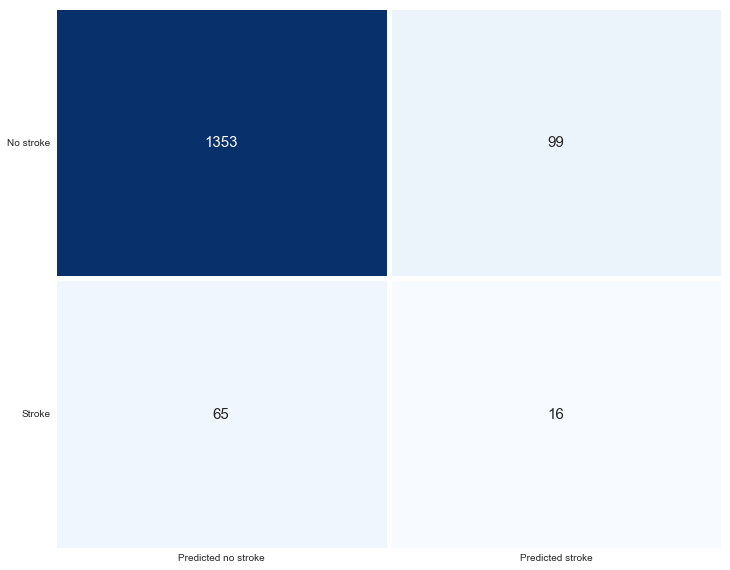

/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


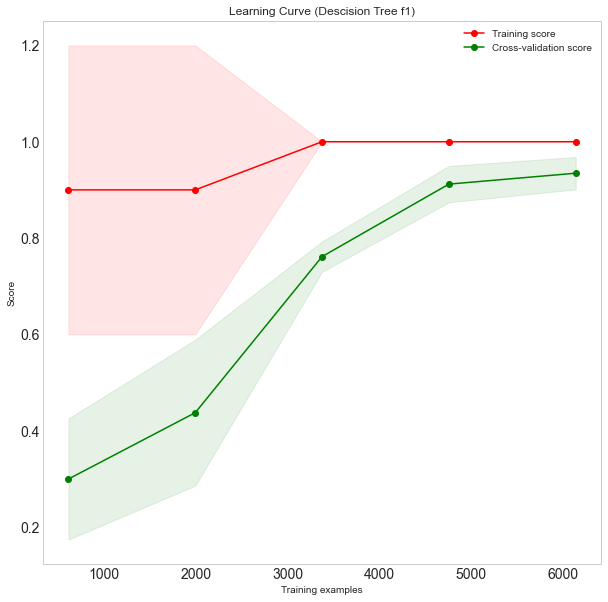

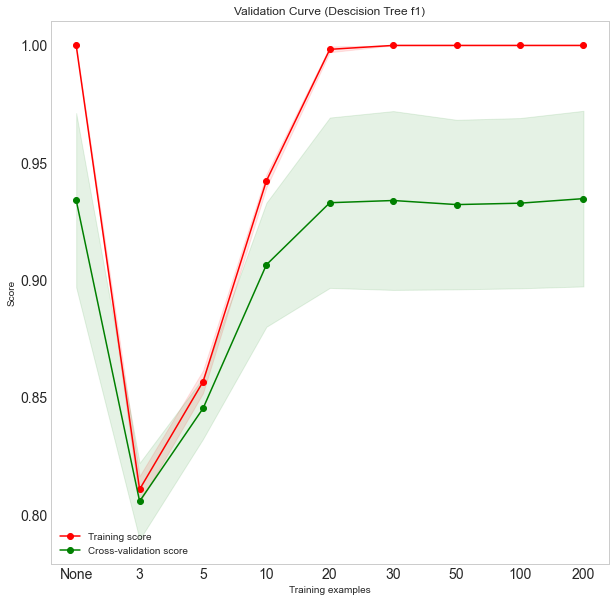

0.948966706917371 {'max_depth': 10}
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1452
           1       0.14      0.37      0.21        81

    accuracy                           0.85      1533
   macro avg       0.55      0.62      0.56      1533
weighted avg       0.92      0.85      0.88      1533



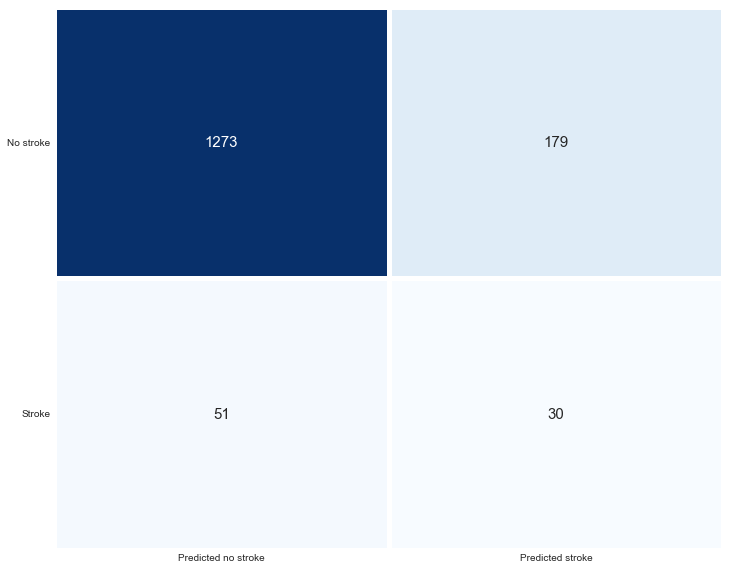

/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


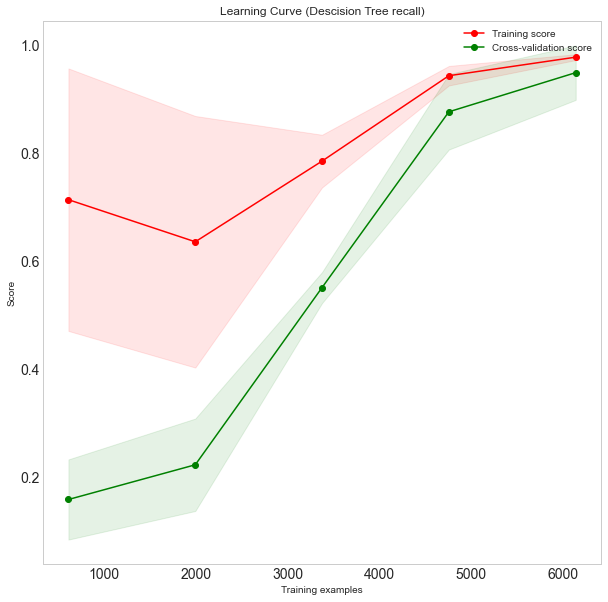

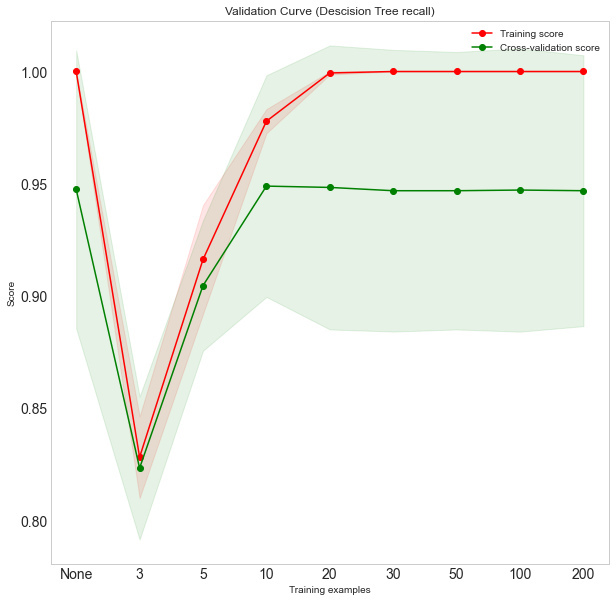

0.7876176482030687 {'max_depth': 20}
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       878
           1       0.79      0.83      0.81       900
           2       0.77      0.79      0.78       847
           3       0.70      0.70      0.70       879

    accuracy                           0.79      3504
   macro avg       0.79      0.79      0.79      3504
weighted avg       0.79      0.79      0.79      3504



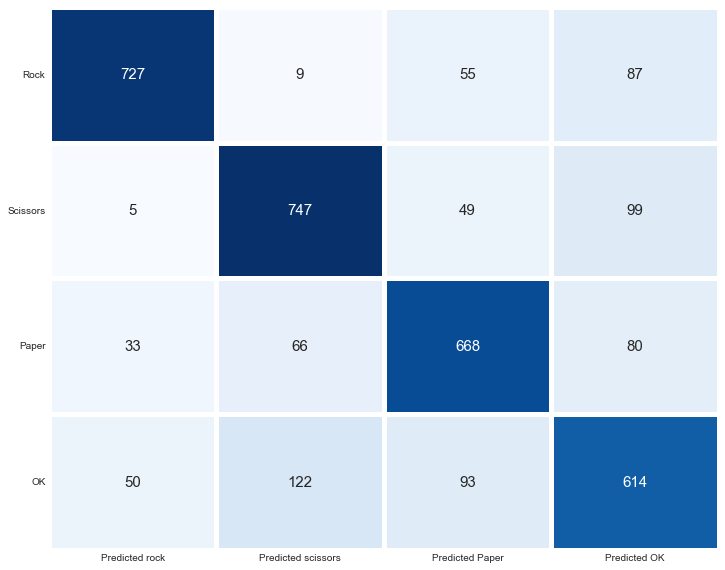

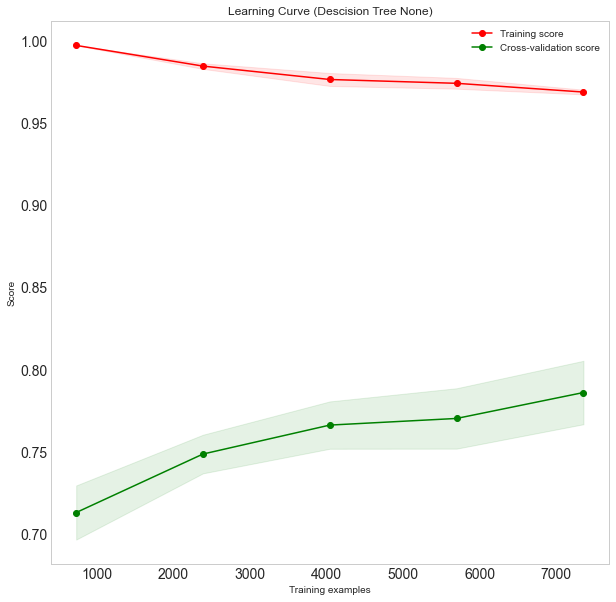

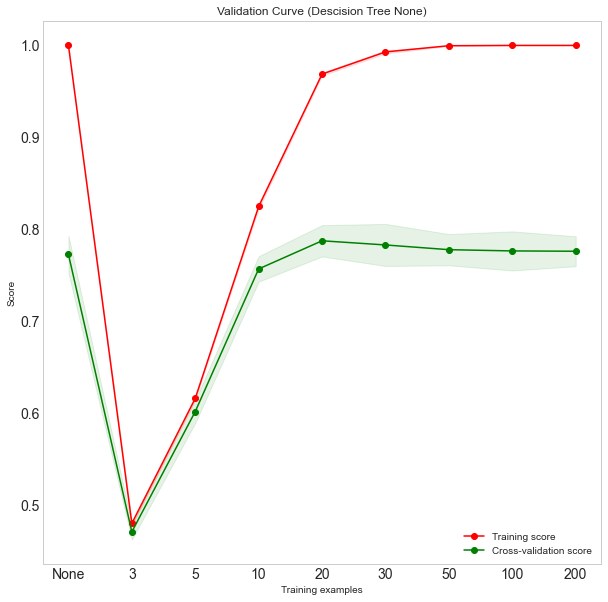

In [93]:
# Decision tree
# Stroke: pruning helped!(ccp_alpha) wth criterion=’entropy’


def decision_tree(type, scoring, cv, data, params = None):
    params = params or {
        # 'ccp_alpha': [0.003, 0.00001, 0.3, 0.1, 0.2, 0.5],
        # "criterion": ["gini", "entropy"],
        "max_depth": [None, 3, 5, 10, 20, 30, 50, 100, 200],
        # "min_samples_split": [2, 4, 10],
    }

    X_train, X_test, y_train, y_test = data
    model = GridSearchCV(
        DecisionTreeClassifier(),
        params,
        n_jobs=-1,
        return_train_score=True,
        scoring=scoring,
        cv=cv,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.best_score_, model.best_params_,)
    print(classification_report(y_test, y_pred))
    show_confusion_matrix(y_test, y_pred, type)
    gen_learning_curve(
        DecisionTreeClassifier(**(model.best_params_)),
        f'Learning Curve (Descision Tree {scoring})',
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
    )

    gen_validation_curve_old(model, 'max_depth', title=f'Validation Curve (Descision Tree {scoring})')


    results = get_all_results(y_test, y_pred, type)
    return results, model.best_params_

dt_results_stroke_f1, best_stroke_dt_f1 = decision_tree('stroke', 'f1', 10, stroke_data)
dt_results_stroke_recall, best_stroke_dt_recall = decision_tree('stroke', 'recall', 10, stroke_data)
dt_results_gesture, best_gesture_dt = decision_tree('gesture', None, 10, gesture_data)


# Neural network

/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

0.8375850085544287 {'hidden_layer_sizes': 5}
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1452
           1       0.15      0.58      0.23        81

    accuracy                           0.80      1533
   macro avg       0.56      0.70      0.56      1533
weighted avg       0.93      0.80      0.85      1533



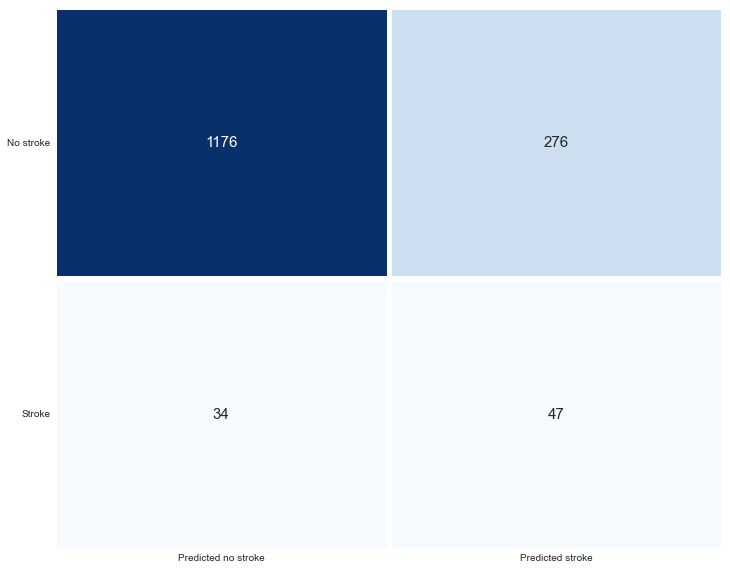

/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer:

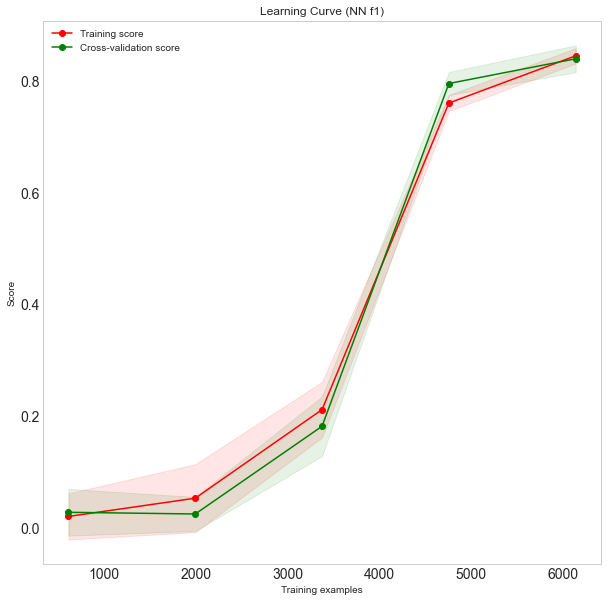

In [23]:
# Neural network

def neural_net(type, scoring, cv, data, params=None):
    X_train, X_test, y_train, y_test = data
    params = params or {
        # 'max_iter': [3000],
        # 'activation': ['identity', 'logistic', 'tanh', 'relu'],
        # 'solver': ['lbfgs', 'sgd', 'adam'],
        'hidden_layer_sizes': (
            # (1,), (2,), (5,), (11,), (21,)
            (1), (2), (5)
        )
    }

    # scale all features for NN
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = GridSearchCV(
        MLPClassifier(),
        params,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Results
    print(model.best_score_, model.best_params_,)
    print(classification_report(y_test, y_pred))
    show_confusion_matrix(y_test, y_pred, type)
    gen_learning_curve(
        MLPClassifier(**(model.best_params_)),
        f'Learning Curve (NN {scoring})',
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
    )

    results = get_all_results(y_test, y_pred, type)
    return results, (X_train, y_train, model)


nn_results_stroke_f1, data = neural_net('stroke', 'f1', 10, stroke_data)


# nn_results_stroke_recall = neural_net('stroke', 'recall', 10, stroke_data)
# nn_result_gesture = neural_net('gesture', None, 10, gesture_data)


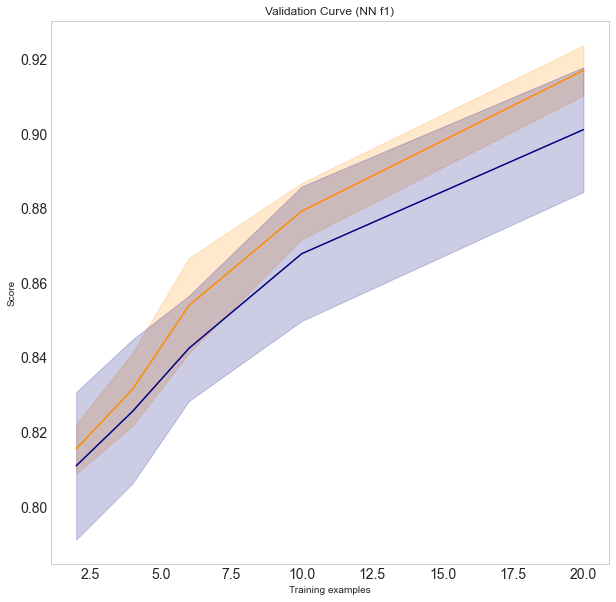

In [27]:

X_train, y_train, model =  data


param_range = ((2), (4), (6), (10), (20))
param_name='hidden_layer_sizes'
scoring = 'f1'
cv=10

train_scores, test_scores = validation_curve(estimator=MLPClassifier(**(model.best_params_)), X=X_train, y=y_train, param_name=param_name,
                                                    param_range=param_range, cv=cv, scoring=scoring)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 10))
plt.tick_params(labelsize=14)
plt.title(f'Validation Curve (NN {scoring})')
plt.xlabel(param_name)
plt.ylabel("Score")
plt.grid()


plt.plot(param_range, train_scores_mean, label="Training score",
        color="darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color="darkorange")
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
        color="navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color="navy")

plt.show()



# Boosted Decision Trees

0.9239156670253686 {'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1452
           1       0.19      0.25      0.21        81

    accuracy                           0.90      1533
   macro avg       0.57      0.59      0.58      1533
weighted avg       0.92      0.90      0.91      1533



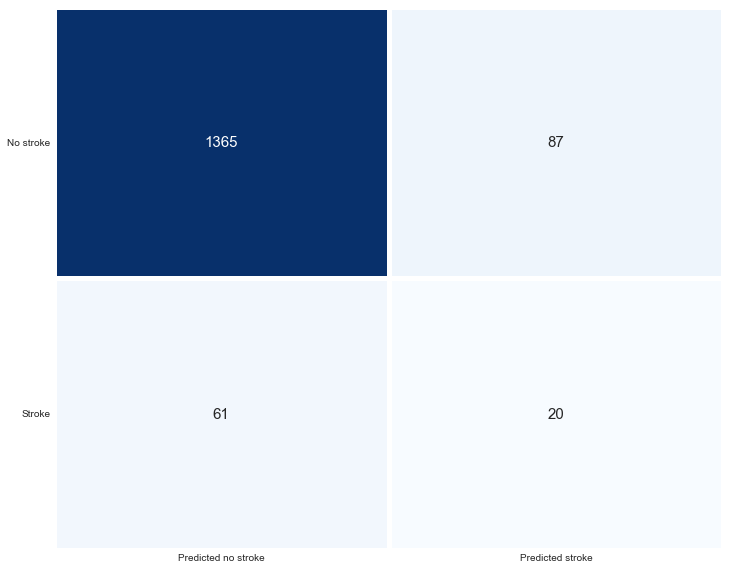

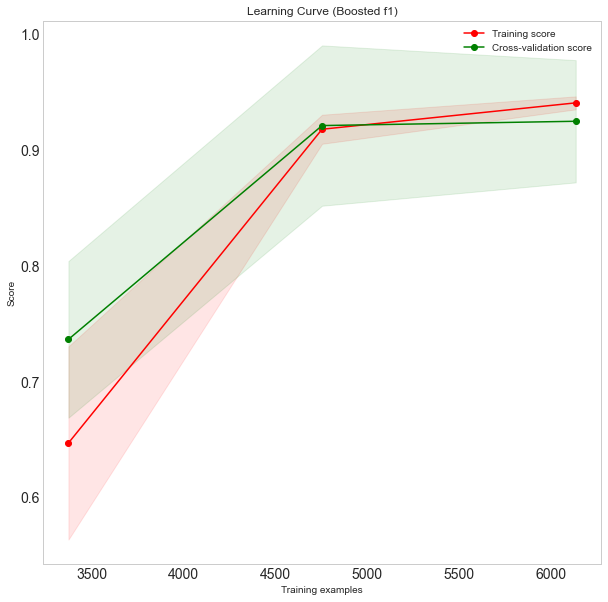

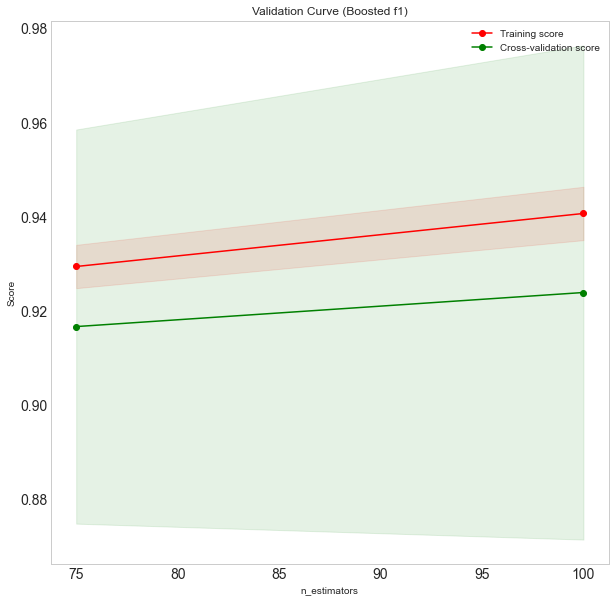

0.9307814386751769 {'n_estimators': 75}
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1452
           1       0.20      0.35      0.25        81

    accuracy                           0.89      1533
   macro avg       0.58      0.63      0.60      1533
weighted avg       0.92      0.89      0.90      1533



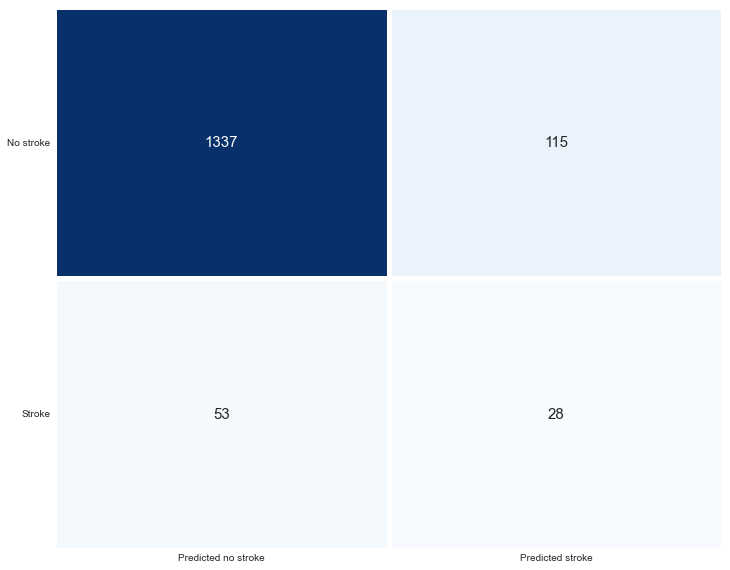

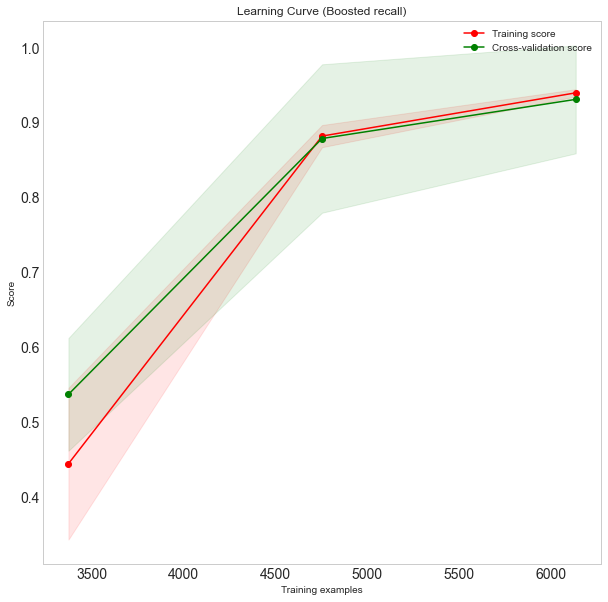

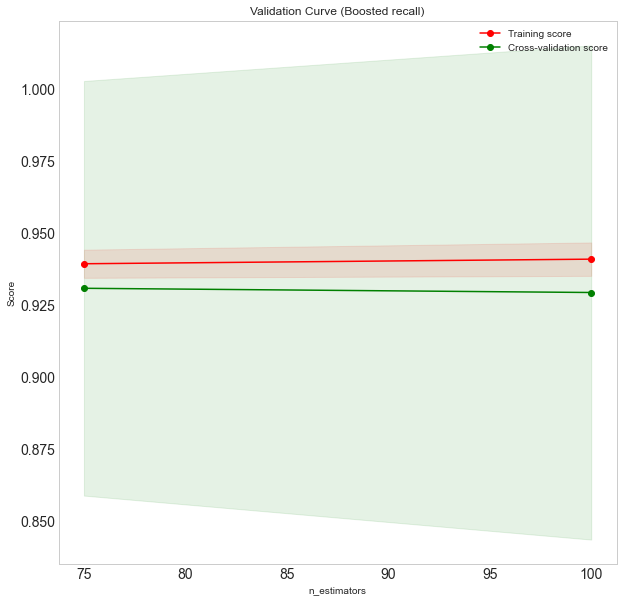

0.9427438927676842 {'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       878
           1       0.94      0.97      0.95       900
           2       0.94      0.93      0.93       847
           3       0.93      0.91      0.92       879

    accuracy                           0.94      3504
   macro avg       0.94      0.94      0.94      3504
weighted avg       0.94      0.94      0.94      3504



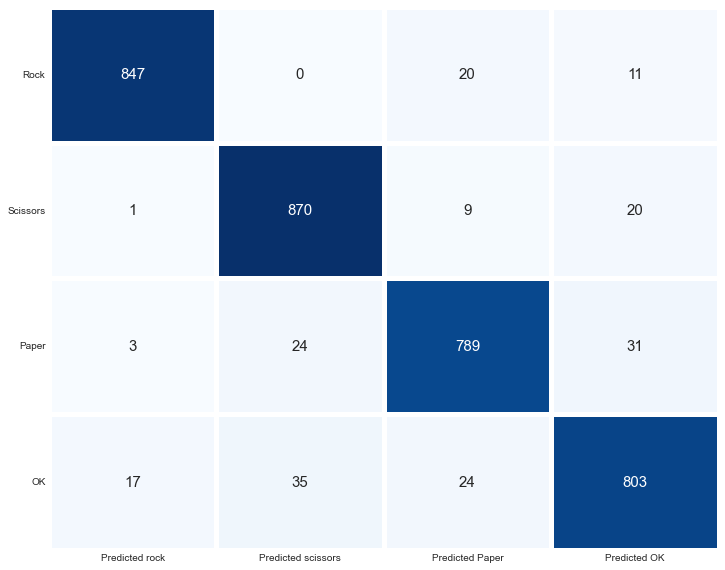

KeyboardInterrupt: 

In [42]:
# Boosted Decision Trees

def boosted_trees(type, scoring, cv, data, params=None):
    params = params or {
        "n_estimators": [5, 20, 50, 75, 100],
        "learning_rate": [0.001, 0.01, 0.1, 0.2, 1.],
    }

    X_train, X_test, y_train, y_test = data


    model = GridSearchCV(
        GradientBoostingClassifier(),
        params,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.best_score_, model.best_params_,)
    print(classification_report(y_test, y_pred))
    show_confusion_matrix(y_test, y_pred, type)
    gen_learning_curve(
        GradientBoostingClassifier(**(model.best_params_)),
        f'Learning Curve (Boosted {scoring})',
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
    )


    # gen_validataion_curve(model, 'n_estimators', title=f'Validation Curve (Boosted Descision Tree {scoring})')
    gen_validataion_curve(
        GradientBoostingClassifier(**(model.best_params_)),
        f'Validation Curve (Boosted {scoring})',
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        param_name='n_estimators',
        param_range=params['n_estimators']
    )

    results = get_all_results(y_test, y_pred, type)
    return results



boost_stroke_result_f1 = boosted_trees('stroke', 'f1', 10, stroke_data)
# boost_stroke_result_recall = boosted_trees('stroke', 'recall', 10, stroke_data)
# boost_gesture_result = boosted_trees('gesture', None, 10, gesture_data)

# Support Vector Machines

In [35]:
# def gen_validataion_curve(algo, title, X, y, cv, train_sizes=np.linspace(.1, 1.0, 5), scoring=None, param_name=None, param_range=None):

#     train_scores, test_scores = validation_curve(
#         algo, X, y, cv=cv, param_name=param_name, param_range=param_range, scoring=scoring, n_jobs=-1)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     plt.figure(figsize=(10, 10))
#     plt.tick_params(labelsize=14)
#     plt.title(title)
#     plt.xlabel(param_name)
#     plt.ylabel("Score")
#     plt.grid()

#     plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
#     plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(param_range, train_scores_mean, 'o-',
#              color="r", label="Training score")
#     plt.plot(param_range, test_scores_mean, 'o-',
#              color="g", label="Cross-validation score")

#     plt.legend(loc="best")
#     plt.show()


---- dataset: stroke, scoring: f1 ---
0.9508378983419474 {'C': 20}
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1452
           1       0.12      0.19      0.15        81

    accuracy                           0.89      1533
   macro avg       0.54      0.56      0.54      1533
weighted avg       0.91      0.89      0.90      1533



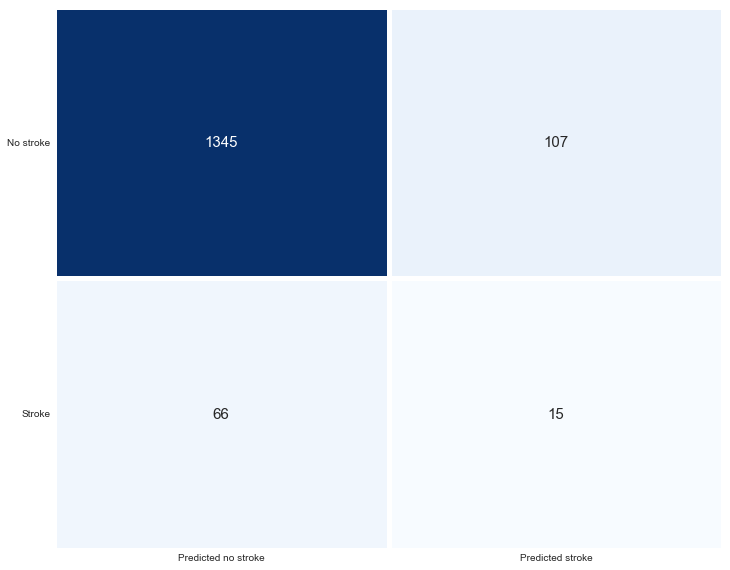

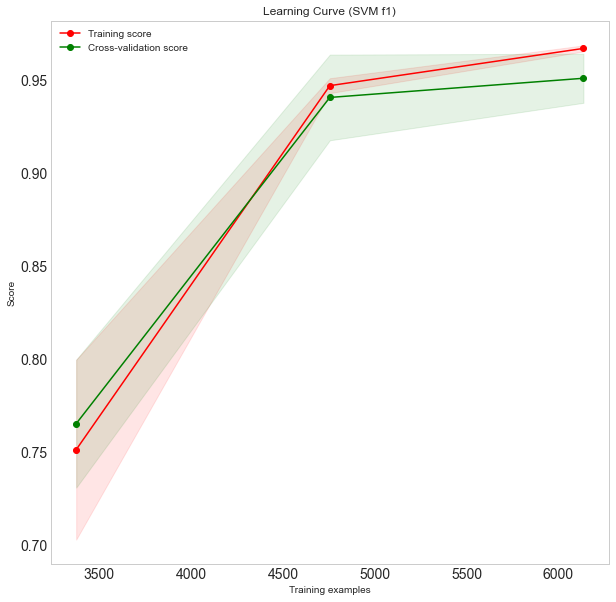

-------


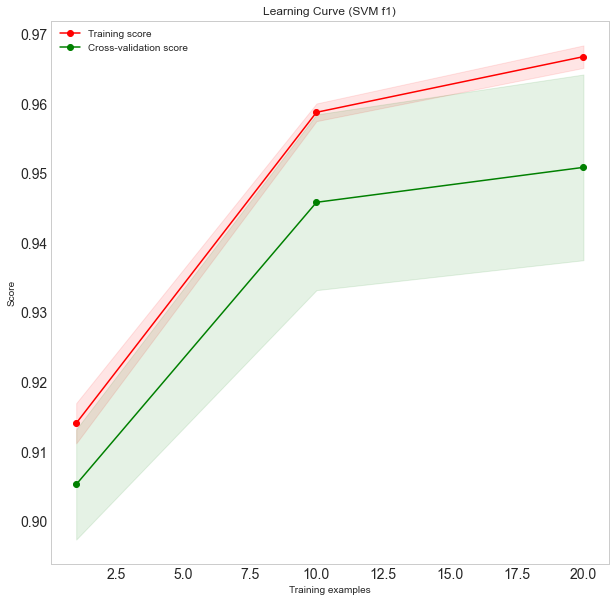

In [109]:
# Support Vector Machines

def svm(type, scoring, cv, data, params = None):
    params = params or {
        # 'kernel': ['rbf', 'sigmoid', 'linear'],
        'C': [1, 10, 20]
    }

    X_train, X_test, y_train, y_test = data
    model = GridSearchCV(
        SVC(),
        params,
        scoring=scoring,
        n_jobs=-1,
        cv=cv,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'---- dataset: {type}, scoring: {scoring} ---')
    print(model.best_score_, model.best_params_,)
    print(classification_report(y_test, y_pred))
    show_confusion_matrix(y_test, y_pred, type)
    gen_learning_curve(
        SVC(**(model.best_params_)),
        f'Learning Curve (SVM {scoring})',
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
    )
    print(f'-------')

    gen_validataion_curve(
        SVC(**(model.best_params_)),
        f'Validation Curve (SVM {scoring})',
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        param_name='C',
        param_range=params['C']
    )

    results = get_all_results(y_test, y_pred, type)

    # gen_validation_curve(model, 'C', title=f'Validation Curve (Descision Tree {scoring})')
    return results


svm_result1 = svm('stroke', 'f1', 10, stroke_data)
# svm_result2 = svm('stroke', 'recall', 10, stroke_data)
# svm_result3 = svm('gesture', None, 10, gesture_data)

# KNN

---- dataset: stroke, scoring: f1 ---
0.9478442150307289 {'n_neighbors': 3, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1452
           1       0.10      0.20      0.13        81

    accuracy                           0.86      1533
   macro avg       0.53      0.55      0.53      1533
weighted avg       0.91      0.86      0.88      1533



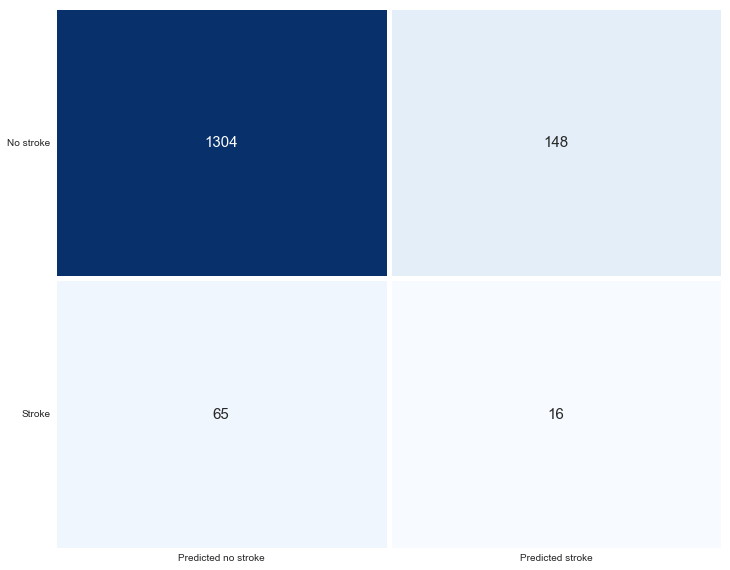

/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/alister/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


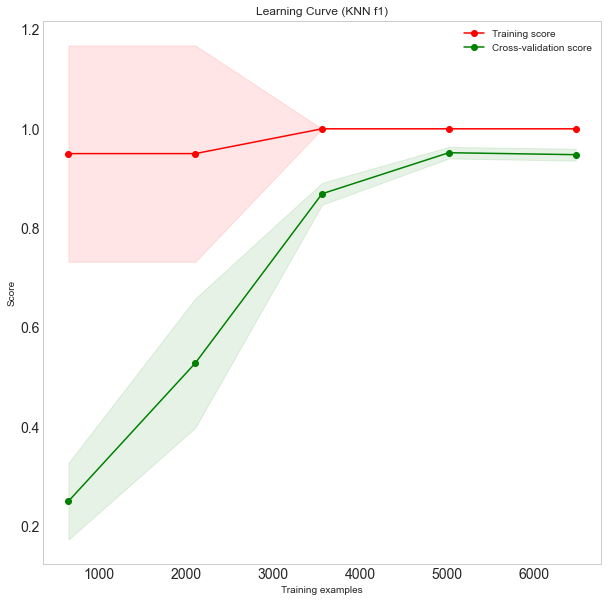

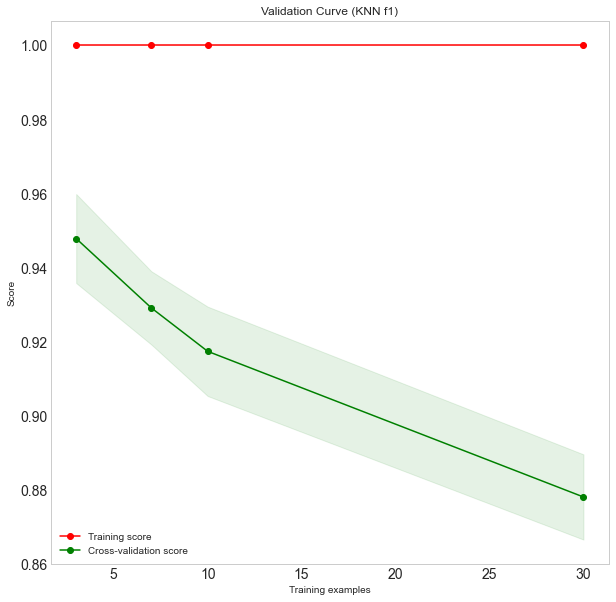

-------


In [111]:
# KNN

def knn(type, scoring, cv, data, params = None):
    params = params or {
        'weights': ('uniform', 'distance'),
        'n_neighbors': [3, 7, 10, 30],
    }

    X_train, X_test, y_train, y_test = data

    model = GridSearchCV(
        KNeighborsClassifier(),
        params,
        n_jobs=-1,
        scoring=scoring,
        return_train_score=True,
        cv=cv,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'---- dataset: {type}, scoring: {scoring} ---')
    print(model.best_score_, model.best_params_,)
    print(classification_report(y_test, y_pred))
    show_confusion_matrix(y_test, y_pred, type)
    scoring_name = scoring or ''
    gen_learning_curve(
        KNeighborsClassifier(**(model.best_params_)),
        f'Learning Curve (KNN {scoring_name})',
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
    )

    gen_validataion_curve(
        KNeighborsClassifier(**(model.best_params_)),
        f'Validation Curve (KNN {scoring})',
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        param_name='n_neighbors',
        param_range=params['n_neighbors']
    )

    print(f'-------')

    results = get_all_results(y_test, y_pred, type)
    return results


knn1 = knn('stroke', 'f1', 20, stroke_data)
# knn2 = knn('stroke', 'recall', 30, stroke_data)
# knn3 = knn('gesture', None, 10, gesture_data)